**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Necessary actions to read the data from the google drive, as the code is written using google colab**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Importing Skin Cancer Data**

**Importing all the important libraries** 

In [2]:
#import the required libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [3]:
## If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

**1.Data Reading/Data Understanding:**

**Paths for train and test images**

In [4]:
# Defining the path for train and test images
root_path = '/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

**Verifying the test train image count**

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2288
118


**2.Dataset Creation:**

**Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

**Train Dataset**

In [7]:
#getting the train dataset here using the keras library, with seed = 123, validation split = 20%, and image resize to 180x180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2288 files belonging to 9 classes.
Using 1831 files for training.


**Validation Dataset**

In [8]:
# getting the validation dataset here using the keras library with same setting as above

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2288 files belonging to 9 classes.
Using 457 files for validation.


In [9]:
# Checking files and classes
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**3.Dataset Visualisation:**

**Visualizing the data**

**Visualizing one instance of all the nine classes present in the dataset**

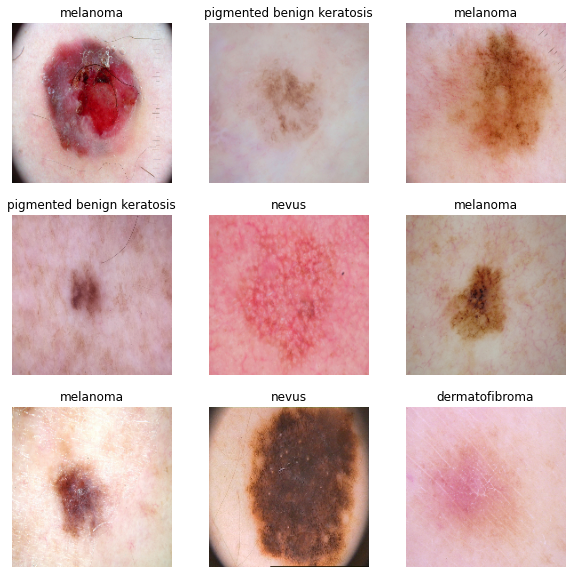

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**4.Model Building & training :** 

**Create the model**

**Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]**

In [13]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [14]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [15]:
### Compiling the model using adam optimiser and binary_crossentropy loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

**Model Summary**

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

**Train the model**

In [17]:
# training  the model with 20 epochs
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
58/58 [==============================] - 614s 2s/step - loss: -81560.1953 - accuracy: 0.1638 - val_loss: -67313.0391 - val_accuracy: 0.1554
Epoch 2/20
58/58 [==============================] - 4s 68ms/step - loss: -867290.0000 - accuracy: 0.1666 - val_loss: -695068.9375 - val_accuracy: 0.1554
Epoch 3/20
58/58 [==============================] - 4s 68ms/step - loss: -3144899.7500 - accuracy: 0.1666 - val_loss: -3259390.2500 - val_accuracy: 0.1554
Epoch 4/20
58/58 [==============================] - 4s 67ms/step - loss: -7774142.0000 - accuracy: 0.1666 - val_loss: -6962205.5000 - val_accuracy: 0.1554
Epoch 5/20
58/58 [==============================] - 4s 67ms/step - loss: -15263625.0000 - accuracy: 0.1666 - val_loss: -11489996.0000 - val_accuracy: 0.1554
Epoch 6/20
58/58 [==============================] - 4s 67ms/step - loss: -26215754.0000 - accuracy: 0.1666 - val_loss: -19283644.0000 - val_accuracy: 0.1554
Epoch 7/20
58/58 [==============================] - 4s 67ms/step - loss:

**Visualizing training results**

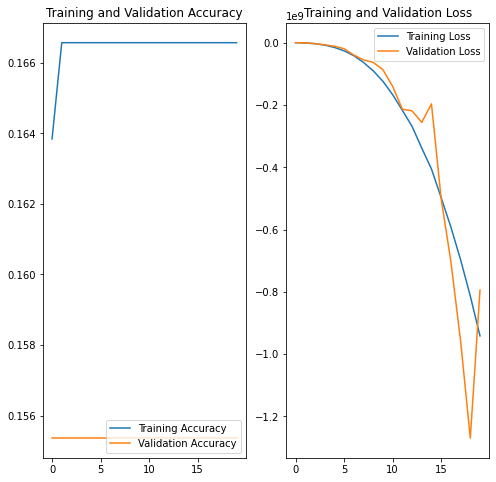

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings from the graph and model history**

**Clearly we can see that the model is overfitting.**

**One of the reasons of overfitting could be lack of sufficient images as we know that CNN model require huge amount of images to learn, hence it looks like the model is memorizing the train images and therefore leading to overfitting**

In [19]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


15/15 [==============================] - 0s 15ms/step - loss: -794494912.0000 - accuracy: 0.1554
Accuracy:  0.16657564043998718
Validation Accuracy:  0.15536105632781982
Loss:  -783808320.0
Validation Loss -794494912.0


As we have seen the model Overfit and we need to chose right data augumentation strategy

**5.Chose an appropriate data augmentation strategy to resolve underfitting/overfitting:** 

**Data Augmentation**

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 919 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


**Visualize Augmented Data**

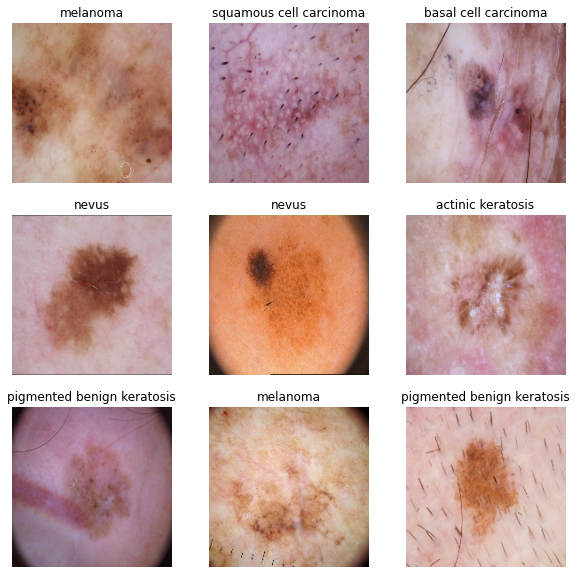

In [21]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**6.Model Building & training on the augmented data :**

In [28]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_73 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_74 (ModuleWr  (None, 180, 180, 32)     9248      
 apper)                                                          
                                                                 
 module_wrapper_75 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_76 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                               

**Compiling the model**

In [31]:
## compiling the model with adam optimizer and categorical_crossentropy as loss function
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [32]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

**Training the model**

In [33]:
## training the model with 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
15/15 [==============================] - 78s 5s/step - loss: 1.9515 - accuracy: 0.4298 - val_loss: 1.6285 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
15/15 [==============================] - 32s 2s/step - loss: 1.0053 - accuracy: 0.4559 - val_loss: 1.5151 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
15/15 [==============================] - 32s 2s/step - loss: 0.9274 - accuracy: 0.5136 - val_loss: 1.4255 - val_accuracy: 0.2292 - lr: 0.0010
Epoch 4/20
15/15 [==============================] - ETA: 0s - loss: 0.8888 - accuracy: 0.5190
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
15/15 [==============================] - 32s 2s/step - loss: 0.8888 - accuracy: 0.5190 - val_loss: 1.2889 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 5/20
15/15 [==============================] - 32s 2s/step - loss: 0.7972 - accuracy: 0.5963 - val_loss: 1.1643 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 6/20
15/15 [==============================] - 31s 2s/step - loss: 

**Visualizing the results**

<built-in method keys of dict object at 0x7f438bc258c0> :


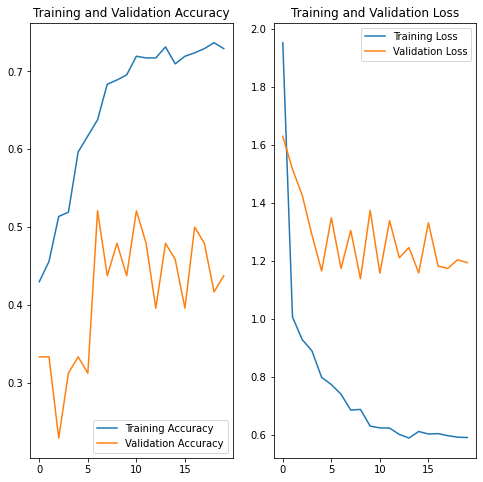

In [34]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**

There has been some improvement now as compared to the previous model as we can see from the train and validation accuracy that the model overfitting has been handled, but the model performance is not so good.

**This is because of class imbalance**.

**Context:** We have to find distribution of classes in the training dataset.
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. 
Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

**7.Class distribution:**

**Plotting graph to detect class imbalance**

In [43]:
# creating the dictionary and dataframe of original train data to plot a bar graph to check the class imbalance
image_dict = {}
for classname in class_names:
    image_dict[classname] = len(list(data_dir_train.glob(classname+'/*.jpg')))   
print(image_dict)  

{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 386, 'pigmented benign keratosis': 482, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


In [44]:
# creating dataframe containing count of images per class
df = pd.DataFrame()
counts = list(image_dict.values())
df['class'] = class_names
df['count'] = counts

In [45]:
df.head(10)

,class,count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,386
5,pigmented benign keratosis,482
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


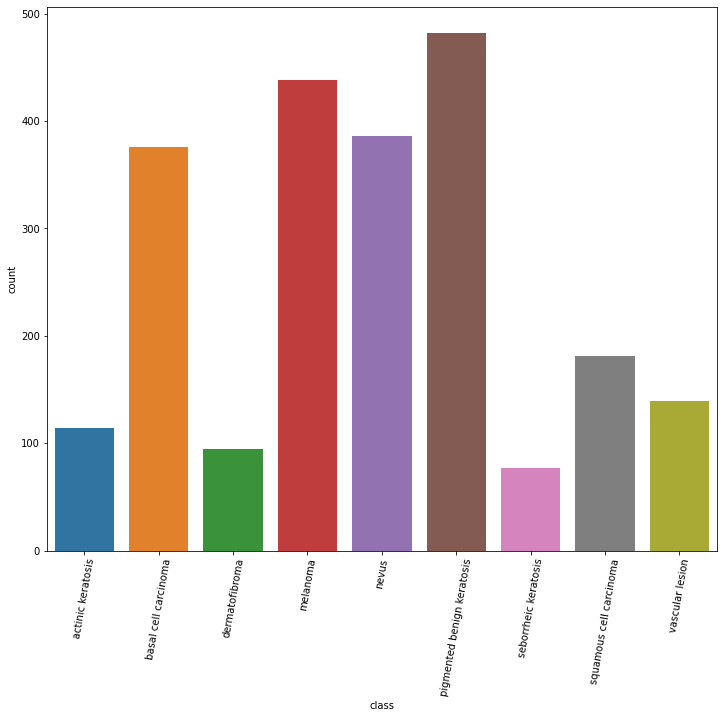

In [47]:
# Plotting the bar graph for each class
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.barplot(x = df['class'], y = df['count'], data = df)
plt.xticks(rotation=80)
plt.show()

**Findings**

**Clearly from above graph we can see that there is a class imbalance issue and the images are not uniformly distributed**

- **seborrheic keratosis class has the least number of samples, that is 77**

- **pigmented benign keratosis, melanoma and basal cell carcinoma are the top 3 dominant classes wrt the sample count**

**To Rectify class imbalance we can use the Augmentor library to add more images to the existing samples which can help to resolve the class imbalance issue.**

**Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.** 

**8.Handling class imbalances:**

In [48]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use Augmentor, the following general procedure is followed:

1.Instantiate a Pipeline object pointing to a directory containing your initial image data set.

2.Define a number of operations to perform on this data set using your Pipeline object.

3.Execute these operations by calling the Pipeline’s sample() method.

In [50]:
path_to_training_dataset='gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
#data_dir_train = pathlib.Path('gdrive/My Drive/colab_dataset/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
## We are adding 500 samples per class to make sure that none of the classes are sparse.
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4400519D10>: 100%|██████████| 500/500 [00:17<00:00, 29.16 Samples/s]


Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F448DD892D0>: 100%|██████████| 500/500 [00:17<00:00, 28.77 Samples/s]


Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4400519D10>: 100%|██████████| 500/500 [00:19<00:00, 26.13 Samples/s]


Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F440053EE50>: 100%|██████████| 500/500 [01:44<00:00,  4.80 Samples/s]


Initialised with 386 image(s) found.
Output directory set to gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F438BE36B10>: 100%|██████████| 500/500 [01:25<00:00,  5.85 Samples/s]


Initialised with 482 image(s) found.
Output directory set to gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4408DE44D0>: 100%|██████████| 500/500 [00:18<00:00, 27.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F43A62A67D0>: 100%|██████████| 500/500 [00:41<00:00, 11.95 Samples/s]


Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F4408D56B50>: 100%|██████████| 500/500 [00:18<00:00, 27.08 Samples/s]


Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F438E57D4D0>: 100%|██████████| 500/500 [00:18<00:00, 27.05 Samples/s]


In [51]:
# sum of sample images added in each class
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [52]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027216.jpg_ccf76bba-30a9-4d3a-9d00-1216b47c8123.jpg',
 '/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029962.jpg_0027b6f4-95ed-427c-a075-c4bc4de94f76.jpg',
 '/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033790.jpg_9ef12210-3df2-41ea-96fd-cc9d917eadea.jpg',
 '/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027107.jpg_a2132e19-353e-4779-86f7-ec1470a8baf3.jpg',
 '/content/gdrive/MyDrive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027044.jpg_ac7

In [53]:
# class list of the added samples
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [54]:
# creating new dataframe with the newly added sample images and then merging with the existing original dataframe
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

new_df['Label'].value_counts()

dermatofibroma                500
seborrheic keratosis          500
actinic keratosis             500
pigmented benign keratosis    500
basal cell carcinoma          500
nevus                         500
vascular lesion               500
squamous cell carcinoma       500
melanoma                      500
Name: Label, dtype: int64


**Train the model on the data created using Augmentor**

In [55]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [57]:
data_dir_train="gdrive/My Drive/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6788 files belonging to 9 classes.
Using 5431 files for training.


**Create a validation dataset**

In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6788 files belonging to 9 classes.
Using 1357 files for validation.


In [61]:
# checking the class names
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [62]:
# Autotune
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**9.Model Building & training on the rectified class imbalance data:**

**Creating the model with added samples using Augmentor library:**

In [63]:
# creating the sequential model with rescaling, 3 conv, 3 maxpooling, 3 dropouts and 2 dense layers
model = Sequential([
    # rescaling layer
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    # 1st conv layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    #2nd conv layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    #3rd conv layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
    # maxpooling layer
  layers.MaxPooling2D(),
    # dropout layer
  layers.Dropout(0.25),
    # flatten
  layers.Flatten(),
    # 1st dense layer
  layers.Dense(128, activation='relu'),
    # output layer with softmax
  layers.Dense(num_classes,activation='softmax')
])

**Compile the model**

In [64]:
# compiling the model with adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Model Summary**

In [65]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

**Training the model**

In [66]:
# trainig the model with 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
170/170 [==============================] - 34s 61ms/step - loss: 2.2073 - accuracy: 0.1591 - val_loss: 2.0000 - val_accuracy: 0.2373
Epoch 2/30
170/170 [==============================] - 4s 25ms/step - loss: 1.7891 - accuracy: 0.3034 - val_loss: 1.7438 - val_accuracy: 0.3353
Epoch 3/30
170/170 [==============================] - 4s 25ms/step - loss: 1.5178 - accuracy: 0.4344 - val_loss: 1.6586 - val_accuracy: 0.3633
Epoch 4/30
170/170 [==============================] - 4s 25ms/step - loss: 1.3224 - accuracy: 0.5130 - val_loss: 1.3412 - val_accuracy: 0.4982
Epoch 5/30
170/170 [==============================] - 4s 25ms/step - loss: 1.2003 - accuracy: 0.5612 - val_loss: 1.2766 - val_accuracy: 0.5298
Epoch 6/30
170/170 [==============================] - 4s 25ms/step - loss: 1.0768 - accuracy: 0.6058 - val_loss: 1.1818 - val_accuracy: 0.5520
Epoch 7/30
170/170 [==============================] - 4s 25ms/step - loss: 1.0129 - accuracy: 0.6266 - val_loss: 1.0351 - val_accuracy: 0.619

**Visualizing the model results**

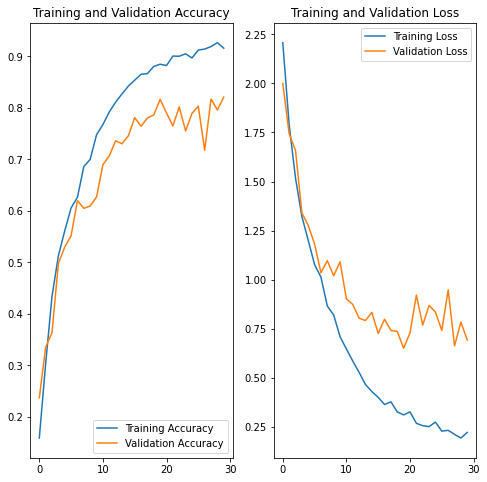

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**10.Conclusion:**

**Findings:**

Finally we handled both overfitting and class imbalance issue and the model performance has increased considerably.
train accuracy 92% and validation accuracy 82%
